In [1]:
import time
import sys
import pathlib
import os
import numpy as np
import cv2 as cv
from spatialmath import SE3
from scipy.spatial.transform import Rotation as R, Slerp
import matplotlib.pyplot as plt
from roboticstoolbox import DHRobot, RevoluteDH
from spatialmath.base import trotx, troty, trotz
import csv
import pathlib
import roboticstoolbox as rtb

notebook_path = os.getcwd()
sys.path.append(str(pathlib.Path(notebook_path).parent))
from classrobot.robot_movement import RobotControl
from classrobot.realsense_cam import RealsenseCam
from classrobot.UR5e_DH import UR5eDH



Loading camera configuration from: c:\Users\COMPUTER3\Desktop\fra631-project\FRA631_Project_Dual_arm_UR5\FRA631_Project_Dual_arm_UR5_Calibration\caribration\config\cam.json
Loading camera matrix from: c:\Users\COMPUTER3\Desktop\fra631-project\FRA631_Project_Dual_arm_UR5\FRA631_Project_Dual_arm_UR5_Calibration\caribration\config\best_matrix.json


In [2]:
HOME_POS = [0.701172053107018, 0.184272460738082, 0.1721568294843568, 
            -1.7318488600590023, 0.686830145115122, -1.731258978679887]

HOME_POS_JOINTS = [0.7144814729690552, -1.9380423031248988, -2.0520365238189697,
                   -2.2719952068724574, -0.9003556410418909, 2.3653483390808105]
GOAL = [0.8256127266378359, 0.12745803218842616, -0.13050644122642596, 
        -1.7318443587261685, 0.686842056802218, -1.7312759524010408]

RPY = [-1.7318443587261685, 0.686842056802218, -1.7312759524010408]
RPY_test =  [-1.7224438319206319, 0.13545161633255984, -1.2975236351897372]

## Class UR5e DH parameters


In [ ]:
# class UR5eDH(DHRobot):
#     def __init__(self, symbolic=False):

#         if symbolic:
#             import spatialmath.base.symbolic as sym

#             zero = sym.zero()
#             pi = sym.pi()
#         else:
#             from math import pi

#             zero = 0.0

#         deg = pi / 180

#         # robot length values (metres)
#         a = [0, -0.42500, -0.3922, 0, 0, 0]
#         d = [0.1625, 0, 0, 0.1333, 0.0997, 0.0996]
#         alpha = [pi / 2, zero, zero, pi / 2, -pi / 2, zero]

#         # mass and center of mass
#         mass = [3.7000, 8.058, 2.846, 1.37, 1.3, 0.365]
#         center_of_mass = [
#             [0, -0.02561, 0.00193],
#             [0.2125, 0, 0.11336],
#             [0.15, 0, 0.0265],
#             [0, -0.0018, 0.01634],
#             [0, 0.0018, 0.01634],
#             [0, 0, -0.001159],
#         ]
#         # inertia tensor
#         inertia = [
#             np.zeros((3, 3)),  # Link 1
#             np.zeros((3, 3)),  # Link 2
#             np.zeros((3, 3)),  # Link 3
#             np.zeros((3, 3)),  # Link 4
#             np.zeros((3, 3)),  # Link 5
#             np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0.0001]]),  # Link 6 (non-zero Izz)
#         ]

#         links = []
#         for j in range(6):
#             link = RevoluteDH(
#                 d=d[j], a=a[j], alpha=alpha[j], m=mass[j], r=center_of_mass[j], G=1, I=inertia[j]
#             )
#             links.append(link)

#         super().__init__(
#             links,
#             name="UR5e",
#             manufacturer="Universal Robotics",
#             keywords=("dynamics", "symbolic"),
#             symbolic=symbolic,
#         )

#         # Named configurations
#         self.qr = np.radians([180, 0, 0, 0, 90, 0])
#         self.qz = np.zeros(6)
#         # Default joint configuration (q)
#         self.q = np.zeros(6)
#         self.q_HOME = [0.7267194390296936, -1.942333837548727, -2.0496392250061035, -2.273778577844137, -0.8829587141620081, 2.369927406311035]
#         self.addconfiguration("qr", self.qr)
#         self.addconfiguration("qz", self.qz)
#         self.addconfiguration("q_HOME", HOME_POS)


#     def set_q(self, q):
#         """
#         Set the robot's joint configuration.
#         """
#         q = np.array(q)
#         if q.shape != (6,):
#             raise ValueError("Joint configuration must be a 6-element vector.")
#         self.q = q


## Function trajectory planning


In [3]:
class Planning:

    def __init__(self, dt=0.01):
        self.dt = dt


    
    def cubic_trajectory(self, p0, p1, v0, v1, T):
        p0, p1, v0, v1 = map(np.array, (p0, p1, v0, v1))
        num_steps = int(np.ceil(T / self.dt)) + 1
        t = np.linspace(0, T, num_steps).reshape(-1, 1)
        a = (2 * (p0 - p1) + (v0 + v1) * T) / (T ** 3)
        b = (3 * (p1 - p0) - (2 * v0 + v1) * T) / (T ** 2)
        pos = a * t**3 + b * t**2 + v0 * t + p0
        vel = 3 * a * t**2 + 2 * b * t + v0
        acc = 6 * a * t + 2 * b
        return t.flatten(), pos, vel, acc
    

    def cubic_trajectory_v1(self, p0, p1, v0, v1, T, dt):
        # ensure numpy arrays
        p0, p1, v0, v1 = map(np.asarray, (p0, p1, v0, v1))
        # time vector
        t = np.arange(0, T + 1e-8, dt)        # include T
        ts = t.reshape(-1, 1)                 # for broadcasting
        
        # coefficients
        a0 = p0
        a1 = v0
        a2 =  3*(p1 - p0)/T**2 - (2*v0 + v1)/T
        a3 = -2*(p1 - p0)/T**3 + (v0 + v1)/T**2
        
        # evaluate
        pos = a0 + a1*ts + a2*ts**2 + a3*ts**3
        vel =      a1   + 2*a2*ts   + 3*a3*ts**2
        acc =           2*a2       + 6*a3*ts

        return t.flatten(), pos, vel, acc

    
    def cubic_trajectory_v2(self, p0, p1, v0, v1, q0, q1, T):

        # --- Translation (cubic) ---
        p0, p1, v0, v1 = map(np.array, (p0, p1, v0, v1))
        num_steps = int(np.ceil(T / self.dt)) + 1
        t = np.linspace(0, T, num_steps).reshape(-1, 1)

        a = (2 * (p0 - p1) + (v0 + v1) * T) / (T ** 3)
        b = (3 * (p1 - p0) - (2 * v0 + v1) * T) / (T ** 2)

        pos = a * t**3 + b * t**2 + v0 * t + p0
        vel = 3 * a * t**2 + 2 * b * t + v0
        acc = 6 * a * t + 2 * b

        # --- Orientation (SLERP) ---
        # Normalize quaternions
        q0 = np.asarray(q0) / np.linalg.norm(q0)
        q1 = np.asarray(q1) / np.linalg.norm(q1)

        # Build SLERP object
        key_rots = R.from_quat([q0, q1])
        slerp = Slerp([0.0, 1.0], key_rots)

        # Normalize time to [0,1]
        tau = t.flatten() / T

        # Interpolate orientations
        orients = slerp(tau).as_quat()

        return t.flatten(), pos, vel, acc, orients
    

    def cubic_trajectory_v3(self, p0, p1, v0, v1, rpy0, rpy1, T):
        """
        Generate a cubic (3rd-order) trajectory for translation and SLERP for orientation,
        using RPY inputs and returning RPY outputs.

        Parameters:
        -----------
        p0   : array_like, shape (3,)
               Start position [x, y, z]
        p1   : array_like, shape (3,)
               End position [x, y, z]
        v0   : array_like, shape (3,)
               Start velocity [vx, vy, vz]
        v1   : array_like, shape (3,)
               End velocity [vx, vy, vz]
        rpy0 : array_like, shape (3,)
               Start orientation as roll, pitch, yaw (rad)
        rpy1 : array_like, shape (3,)
               End orientation as roll, pitch, yaw (rad)
        T    : float
               Total trajectory time

        Returns:
        --------
        t        : ndarray, shape (N,)
                   Time vector
        pos      : ndarray, shape (N,3)
                   Positions along the cubic trajectory
        vel      : ndarray, shape (N,3)
                   Velocities along the cubic trajectory
        acc      : ndarray, shape (N,3)
                   Accelerations along the cubic trajectory
        rpy_traj : ndarray, shape (N,3)
                   SLERP-interpolated roll, pitch, yaw angles (rad)
        """
        # Translation (cubic)
        p0, p1, v0, v1 = map(np.array, (p0, p1, v0, v1))
        num_steps = int(np.ceil(T / self.dt)) + 1
        t = np.linspace(0, T, num_steps).reshape(-1, 1)

        a = (2 * (p0 - p1) + (v0 + v1) * T) / (T ** 3)
        b = (3 * (p1 - p0) - (2 * v0 + v1) * T) / (T ** 2)

        pos = a * t**3 + b * t**2 + v0 * t + p0
        vel = 3 * a * t**2 + 2 * b * t + v0
        acc = 6 * a * t + 2 * b

        # Orientation (SLERP) with RPY I/O
        # Convert RPY to quaternions
        q0 = R.from_euler('xyz', rpy0, degrees=False).as_quat()
        q1 = R.from_euler('xyz', rpy1, degrees=False).as_quat()

        # Build SLERP
        key_rots = R.from_quat([q0, q1])
        slerp = Slerp([0.0, 1.0], key_rots)
        tau = t.flatten() / T

        # Interpolate and convert back to RPY
        quats = slerp(tau).as_quat()
        rpy_traj = R.from_quat(quats).as_euler('xyz', degrees=False)

        return t.flatten(), pos, vel, acc, rpy_traj
    
    def quintic_trajectory(self, p0, p1, v0, v1, q0, q1, T):
        """
        Generate a quintic (5th-order) SE(3) trajectory from p0 to p1 and q0 to q1
        with boundary conditions on position, velocity, and zero acceleration.
        
        Returns:
        t       – (N,) time vector
        pos     – (N, len(p0)) positions
        vel     – (N, len(p0)) velocities
        acc     – (N, len(p0)) accelerations
        orients – (N,4) quaternions (x,y,z,w)
        """
        # Ensure inputs are numpy arrays
        p0, p1, v0, v1 = map(np.array, (p0, p1, v0, v1))
        q0 = np.asarray(q0) / np.linalg.norm(q0)
        q1 = np.asarray(q1) / np.linalg.norm(q1)

        # Time vector
        num_steps = int(np.ceil(T / self.dt)) + 1
        t = np.linspace(0, T, num_steps)
        ts = t.reshape(-1, 1)

        # Quintic translation coefficients (zero accel endpoints)
        a0 = p0
        a1 = v0
        a2 = np.zeros_like(p0)

        # Powers of T
        T2, T3, T4, T5 = T**2, T**3, T**4, T**5

        # Solve for a3, a4, a5
        M = np.array([
            [   T3,    T4,    T5],
            [ 3*T2,  4*T3,  5*T4],
            [ 6*T , 12*T2, 20*T3]
        ])
        M_inv = np.linalg.inv(M)
        dp = p1 - p0
        rhs = np.vstack([
            dp - v0 * T,
            v1 - v0,
            np.zeros_like(p0)
        ])
        a3, a4, a5 = M_inv.dot(rhs)

        # Evaluate position, velocity, acceleration
        pos = a0 + a1*ts + a2*ts**2 + a3*ts**3 + a4*ts**4 + a5*ts**5
        vel =    a1 + 2*a2*ts   + 3*a3*ts**2 + 4*a4*ts**3 + 5*a5*ts**4
        acc =       2*a2       + 6*a3*ts     +12*a4*ts**2  +20*a5*ts**3

        return t, pos, vel, acc
    

    def quintic_trajectory_v2(self, p0, p1, v0, v1, rpy0, rpy1, T):
        """
        Generate a quintic (5th-order) SE(3) trajectory from p0 to p1
        and from rpy0 to rpy1, with boundary conditions on position,
        velocity, and zero acceleration.

        Parameters:
        -----------
        p0   : array_like, shape (3,)
               Start position [x, y, z]
        p1   : array_like, shape (3,)
               End position [x, y, z]
        v0   : array_like, shape (3,)
               Start velocity [vx, vy, vz]
        v1   : array_like, shape (3,)
               End velocity [vx, vy, vz]
        rpy0 : array_like, shape (3,)
               Start orientation as roll, pitch, yaw (rad)
        rpy1 : array_like, shape (3,)
               End orientation as roll, pitch, yaw (rad)
        T    : float
               Total trajectory duration (s)

        Returns:
        --------
        t       : ndarray, shape (N,)
                  Time vector
        pos     : ndarray, shape (N,3)
                  Positions along the quintic trajectory
        vel     : ndarray, shape (N,3)
                  Velocities along the quintic trajectory
        acc     : ndarray, shape (N,3)
                  Accelerations along the quintic trajectory
        rpy_traj: ndarray, shape (N,3)
                  Interpolated roll, pitch, yaw angles (rad)
        """
        # --- ensure array inputs ---
        p0, p1, v0, v1 = map(np.array, (p0, p1, v0, v1))
        rpy0 = np.array(rpy0)
        rpy1 = np.array(rpy1)

        # --- time vector ---
        num_steps = int(np.ceil(T / self.dt)) + 1
        t = np.linspace(0, T, num_steps)
        ts = t.reshape(-1, 1)

        # --- quintic translation ---
        a0 = p0
        a1 = v0
        a2 = np.zeros_like(p0)

        # Powers of T
        T2, T3, T4, T5 = T**2, T**3, T**4, T**5

        # Reduced system for a3, a4, a5
        M = np.array([
            [   T3,    T4,    T5],
            [ 3*T2,  4*T3,  5*T4],
            [ 6*T , 12*T2, 20*T3]
        ])
        rhs = np.vstack([
            (p1 - p0) - v0 * T,
            v1 - v0,
            np.zeros_like(p0)
        ])
        a3, a4, a5 = np.linalg.inv(M).dot(rhs)

        pos = a0 + a1*ts + a2*ts**2 + a3*ts**3 + a4*ts**4 + a5*ts**5
        vel =    a1 + 2*a2*ts   + 3*a3*ts**2 + 4*a4*ts**3 + 5*a5*ts**4
        acc =       2*a2       + 6*a3*ts     +12*a4*ts**2  +20*a5*ts**3

        # --- SLERP orientation from RPY ---
        # Convert RPY to quaternions
        q0 = R.from_euler('xyz', rpy0, degrees=False).as_quat()
        q1 = R.from_euler('xyz', rpy1, degrees=False).as_quat()

        # SLERP setup
        slerp = Slerp([0.0, 1.0], R.from_quat([q0, q1]))
        tau = t / T
        quats = slerp(tau).as_quat()  # array (N,4)

        # Convert back to RPY
        rpy_traj = R.from_quat(quats).as_euler('xyz', degrees=False)

        return t, pos, vel, acc, rpy_traj

    def slerp_orientation(t: np.ndarray, q0: np.array, q1: np.array, T: float) -> np.ndarray:
        """
        SLERP-interpolate between two unit quaternions over timestamps t.

        Parameters:
        -----------
        t  : array_like, shape (N,)
            Time samples (0 <= t_i <= T).
        q0 : array_like, shape (4,)
            Start quaternion (x, y, z, w).
        q1 : array_like, shape (4,)
            End quaternion (x, y, z, w).
        T  : float
            Total interpolation time.

        Returns:
        --------
        orients : ndarray, shape (N,4)
            Interpolated quaternions at each t[i].
        """
        t = np.asarray(t)
        if np.any(t < 0) or np.any(t > T):
            raise ValueError("All t values must lie within [0, T].")

        # Normalize input quaternions
        q0 = np.asarray(q0) / np.linalg.norm(q0)
        q1 = np.asarray(q1) / np.linalg.norm(q1)

        # Build SLERP object over [0,1]
        key_rots = R.from_quat([q0, q1])
        slerp = Slerp([0.0, 1.0], key_rots)

        # Normalize t to [0,1]
        tau = t / T

        # Compute SLERP and return as (x,y,z,w)
        return slerp(tau).as_quat()

    # def compute_traj_time(self, d, v_tool, a_max):
    #     if d < (v_tool ** 2) / a_max:
    #         T_total = 2 * np.sqrt(d / a_max)
    #         profile = 'Triangular'
    #     else:
    #         T_accel = v_tool / a_max
    #         d_accel = 0.5 * a_max * T_accel ** 2
    #         d_ramps = 2 * d_accel
    #         T_total = 2 * T_accel + (d - d_ramps) / v_tool
    #         profile = 'Trapezoidal'
    #     return T_total, profile
    

    def compute_traj_time(self, d, v_tool, a_max):

        # --- Sanity checks ---
        if d < 0:
            raise ValueError("Distance d must be non‑negative")
        if v_tool <= 0 or a_max <= 0:
            raise ValueError("v_tool and a_max must both be > 0")

        # distance needed to accelerate from 0→v_tool and then decel back to 0
        d_ramps = v_tool**2 / a_max

        if d <= d_ramps:
            # never reaches v_tool → triangular
            profile = 'Triangular'
            t_accel = np.sqrt(d / a_max)
            t_const = 0.0
            t_decel = t_accel
        else:
            # trapezoidal: accel → cruise → decel
            profile = 'Trapezoidal'
            t_accel = v_tool / a_max
            t_const = (d - d_ramps) / v_tool
            t_decel = t_accel

        T_total = t_accel + t_const + t_decel
        return T_total, profile

    def plot_waypoints(self, waypoints, pos_start, pos_end):
        pos = np.array([T.t for T in waypoints])
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], color='red', label="Waypoints", s=1)
        ax.scatter(pos_start[0], pos_start[1], pos_start[2], color='green', s=50, label="Start")
        ax.scatter(pos_end[0], pos_end[1], pos_end[2], color='blue', s=50, label="End")
        ax.set_xlabel('X [m]')
        ax.set_ylabel('Y [m]')
        ax.set_zlabel('Z [m]')
        ax.legend()
        plt.show()

    def plot_speeds(self, t_vec, speed_traj, traj_T):
        angular_speeds = np.zeros((len(traj_T), 3))
        for i in range(1, len(traj_T)):
            delta_T = traj_T[i-1].inv() * traj_T[i]
            angular_speeds[i, :] = delta_T.angvec()[0] / self.dt
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(t_vec, speed_traj[:, 0], 'r-', label='Linear X')
        plt.plot(t_vec, speed_traj[:, 1], 'g-', label='Linear Y')
        plt.plot(t_vec, speed_traj[:, 2], 'b-', label='Linear Z')
        plt.legend()
        plt.grid(True)
        plt.subplot(2, 1, 2)
        plt.plot(t_vec, angular_speeds[:, 0], 'r-', label='Angular X')
        plt.plot(t_vec, angular_speeds[:, 1], 'g-', label='Angular Y')
        plt.plot(t_vec, angular_speeds[:, 2], 'b-', label='Angular Z')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def log_waypoints(self, waypoints, path):
        file_path = pathlib.Path(path) / "waypoints_log.csv"
        if os.path.exists(file_path):
            raise FileExistsError(f"{file_path} already exists.")
        with open(file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["X", "Y", "Z", "Roll", "Pitch", "Yaw"])
            for wp in waypoints:
                writer.writerow(wp.t.tolist() + list(wp.rpy()))
        print(f"Waypoints logged to {file_path}")

    def log_joint_trajectory(self, joint_trajectory, path):
        file_path = pathlib.Path(path) / "joint_trajectory_log.csv"
        if os.path.exists(file_path):
            raise FileExistsError(f"{file_path} already exists.")
        with open(file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Joint1", "Joint2", "Joint3", "Joint4", "Joint5", "Joint6"])
            for q in joint_trajectory:
                writer.writerow(q)
        print(f"Joint trajectory logged to {file_path}")

    def load_waypoints(self, path):
        file_path = pathlib.Path(path) / "waypoints_log.csv"
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"{file_path} does not exist.")
        waypoints = []
        with open(file_path, mode='r') as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                x, y, z, roll, pitch, yaw = map(float, row)
                T = SE3(x, y, z) * SE3.RPY(roll, pitch, yaw)
                waypoints.append(T)
        print(f"Waypoints loaded from {file_path}")
        return waypoints
    
    def compute_joint_trajectory(self, traj_T, real_robot):
        joint_trajectory = []
        for idx, T_pose in enumerate(traj_T):
            tcp_pose = T_pose.t.tolist() + list(T_pose.rpy())
            q = real_robot.robot_get_ik(tcp_pose)
            if q is None:
                raise RuntimeError(f"IK failed for waypoint {idx}")
            joint_trajectory.append(q)
        print("Joint trajectory computed successfully.")
        return joint_trajectory

    def compute_joint_trajectory_from_q_robot(self, q_robot):
        joint_trajectory = []
        for idx, T_pose in enumerate(q_robot):
            q = q_robot[idx]
            if q is None:
                raise RuntimeError(f"IK failed for waypoint {idx}")
            joint_trajectory.append(q)
        print("Joint trajectory computed successfully.")
        return joint_trajectory
    
    def load_joint_trajectory(self, path):
        file_path = pathlib.Path(path) / "joint_trajectory_log.csv"
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"{file_path} does not exist.")
        joint_trajectory = []
        df = pd.read_csv(file_path)
        # Extract joint configurations from the DataFrame
        for index, row in df.iterrows():
            joint_config = row.values.tolist()  # Convert the row to a list
            joint_trajectory.append(joint_config)
        return joint_trajectory

In [4]:
# init cam 
cam = RealsenseCam()

# Robot UR5e DH parameters
robotDH = UR5eDH()
tool_offset = SE3(0, 0, 0.200)
robotDH.tool = tool_offset
# T_world = SE3(0, 0, -0.055) * SE3.Rx(0) * SE3.Ry(np.deg2rad(90)) * SE3.Rz(0)
# T_inv = T_world.inv()
# Set the robot's base transformation:
# robotDH.base = T_inv
print(robotDH)

# Robot UR5e connection
robot_ip = "192.168.200.10"
real_robot = RobotControl()
real_robot.robot_release()
real_robot.robot_init(robot_ip)
real_robot.robo_move_home()


RealSense camera started with aligned color and depth streams (640x480@30fps)
Loaded matrix name: camera_to_TCP_transform
RealsenseCam initialized with width: 640, height: 480, fps: 30
DHRobot: UR5e (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │   aⱼ    │   ⍺ⱼ   │
├─────┼────────┼─────────┼────────┤
│  q1 │ 0.1625 │       0 │  90.0° │
│  q2 │      0 │  -0.425 │   0.0° │
│  q3 │      0 │ -0.3922 │   0.0° │
│  q4 │ 0.1333 │       0 │  90.0° │
│  q5 │ 0.0997 │       0 │ -90.0° │
│  q6 │ 0.0996 │       0 │   0.0° │
└─────┴────────┴─────────┴────────┘

┌──────┬─────────────────────────────────────┐
│ tool │ t = 0, 0, 0.2; rpy/xyz = 0°, 0°, 0° │
└──────┴─────────────────────────────────────┘

┌────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│   name │ q0     │ q1     │ q2     │ q3     │ q4     │ q5     │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ q_HOME │  40.2° │  10.6°

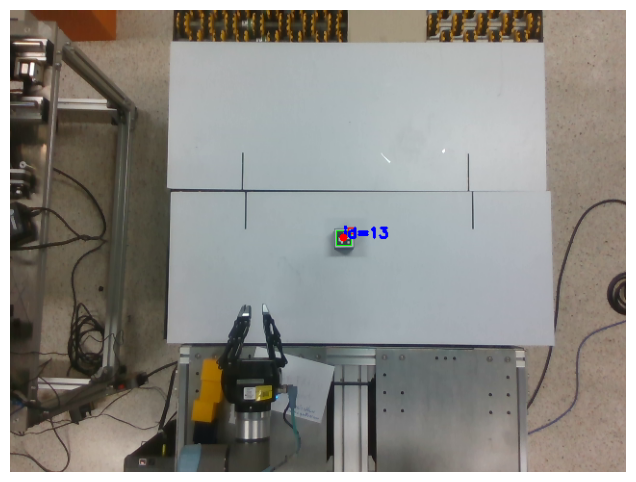

Marker position: [{'id': 13, 'point': Point3D(x=0.058, y=-0.041, z=1.487)}]
Transformed marker position: [{'id': 13, 'point': Point3D(x=0.871, y=0.325, z=-0.035)}]
Transformed marker position: 0.8714601230189104 0.3246385799670448 -0.035035390455956265
End effector position: [0.9214601230189104, 0.1246385799670448, -0.035035390455956265, -1.7318443587261685, 0.686842056802218, -1.7312759524010408]


In [5]:
# Get marker position from cam 
aruco_dict_type = cv.aruco.DICT_5X5_1000
marker_pos = cam.cam_capture_marker_jupyter(aruco_dict_type)
print("Marker position:", marker_pos)
# mutiply with matrix
transfrom_point = cam.transform_marker_points(marker_pos)
print("Transformed marker position:", transfrom_point)
point = transfrom_point[0]["point"]  # Access the first element of the list and then the "point" key.
print("Transformed marker position:", point.x, point.y, point.z)
pos_end = [point.x+0.05, point.y-0.20, point.z] + RPY
print("End effector position:", pos_end)

In [6]:
pos_current = real_robot.robot_get_position()
# pos_end = GOAL
# pos_current = HOME_POS
T_current = SE3(pos_current[0], pos_current[1], pos_current[2]) @ SE3.RPY(pos_current[3], pos_current[4], pos_current[5], unit='rad')

joint_position  = real_robot.robot_get_joint_rad()
print("Current joint position:\n", joint_position)
# joint_position = HOME_POS_JOINTS
robotDH.q = joint_position
T_fk = robotDH.fkine(robotDH.q)
print("FK position:\n", T_fk)

T_end   = SE3(pos_end[0], pos_end[1], pos_end[2]) @ SE3.RPY(pos_end[3], pos_end[4], pos_end[5], unit='rad')

print("Start TCP Pose:\n", T_current)

# compare error between T_fk and T_current
# Calculate RMSE for translation and rotation errors
translation_error = T_fk.t - T_current.t
rotation_error = T_fk.rpy() - T_current.rpy()

rmse_translation = np.sqrt(np.mean(translation_error**2))
rmse_rotation = np.sqrt(np.mean(rotation_error**2))

print("RMSE Translation error between FK and current pose:", rmse_translation)
print("RMSE Rotation error (RPY) between FK and current pose:", rmse_rotation)


# print("Target TCP Pose:\n", T_end)

# Test get pose from RObotics Toolbox
# T_test = robotDH.fkine(joint_position)
# print("FK from Robotics Toolbox:\n", T_test)



# T_test_inv = real_robot.robot_get_ik(pos_current)
# print("IK from Robotics Toolbox:\n", T_test_inv)


Current joint position:
 [0.7145025730133057, -1.9380389652647914, -2.0520005226135254, -2.272055765191549, -0.900362793599264, 2.3653244972229004]
FK position:
    0.02035   0.04231   0.9989    0.6994    
  -0.7225   -0.69      0.04394   0.1837    
   0.6911   -0.7226    0.01652   0.1702    
   0         0         0         1         

Start TCP Pose:
   -0.1235   -0.05824   0.9906    0.7012    
  -0.7633    0.6435   -0.05736   0.1843    
  -0.6341   -0.7632   -0.1239    0.1722    
   0         0         0         1         

RMSE Translation error between FK and current pose: 0.0015915640677299822
RMSE Rotation error (RPY) between FK and current pose: 0.8507935416538608


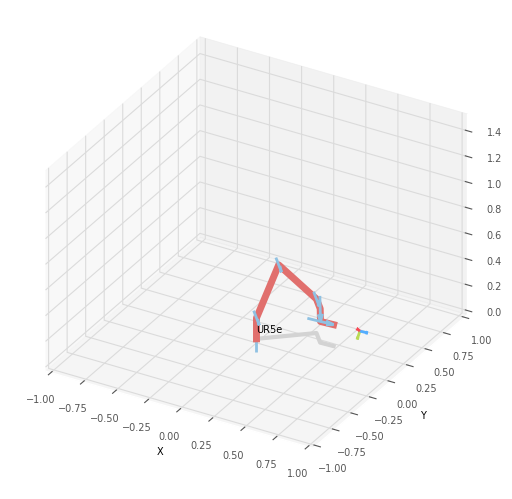

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5e')

<Figure size 640x480 with 0 Axes>

In [7]:
robotDH.plot(joint_position, block=False, limits=[-1, 1, -1, 1, 0, 1.5],vellipse=False)

## Cubic polynomial trajectory planning

In [8]:
# init planning class
planning = Planning()

# Zero initial and final Cartesian velocities (for a smooth start/stop)
v0_cart = 0.0
v1_cart = 0.0

# Extract the translation from T_start and T_end
pos_start = T_current.t  # This is a (3,) numpy array [x, y, z]
pos_end   = T_end.t
# Extract the roll, pitch, yaw angles from T_start and T_end
rpy_start = T_current.rpy()
rpy_end   = T_end.rpy()
print("Start position:", pos_start)
print("End position:", pos_end)
# cal distance between start and end position
dist = np.linalg.norm(pos_end - pos_start)
print("Distance between start and end position:", dist)
# Define the total trajectory duration (seconds)
v_tool = 0.1     # Desired tool speed in m/s
a_max = 0.5     # Maximum acceleration in m/s^2
T_total, profile = planning.compute_traj_time(dist, v_tool, a_max)
print("Selected Profile:", profile)
print("Total Trajectory Time: {:.3f} seconds".format(T_total))

dt = 1/100  # Control loop time step (seconds)
num_steps = int(np.ceil(T_total / dt)) + 1  # Use np.ceil for consistency
t_vec = np.linspace(0, T_total, num_steps)


# Generate the translational (x, y, z) trajectory using cubic interpolation.
pos_traj = np.zeros((len(t_vec), 3))
speed_traj = np.zeros((len(t_vec), 3))  # Initialize speed trajectory array
acc_traj = np.zeros((len(t_vec), 3))  # Initialize acceleration trajectory array
# rpy_traj = np.zeros((len(t_vec), 3))  # Initialize RPY trajectory array



for axis in range(3):
    t_arr, p_arr, v_arr, a_arr = planning.cubic_trajectory(
        pos_start[axis], pos_end[axis], v0_cart, v1_cart, T_total
    )
    pos_traj[:, axis] = p_arr.flatten()
    speed_traj[:, axis] = v_arr.flatten()
    acc_traj[:, axis] = a_arr.flatten()

# how many points in the trajectory?
print("Number of points in the trajectory:", len(pos_traj))
# print("Number of points in the trajectory:", len(rpy_traj))
print("Number of points in the trajectory:", len(speed_traj))
print("Number of points in the trajectory:", len(acc_traj))

# print("rpy at start (x-axis):", rpy_traj[-1])

# Check the endpoints for speed (should be 0)
print("Speed at start (x-axis):", speed_traj[0, 0])
print("Speed at end (x-axis):", speed_traj[-1, 0])
print("Number of trajectory points:", len(pos_traj))


# how many points in the trajectory?
print("Number of points in the trajectory:", len(pos_traj))


# # For the orientation, interpolate using the SE3.interp method.
# traj_T = []
# for j, t in enumerate(t_vec):
#     s = t / T_total  # normalized time [0, 1]
#     T_interp = T_current.interp(T_end, s)  # Interpolate orientation
#     # Replace the translation with the cubic trajectory value for consistency:
#     T_interp = SE3.Rt(T_interp.R[:3, :3], pos_traj[j, :])
#     traj_T.append(T_interp)


# 1) get start/end quaternions (x,y,z,w) from your SE3s
q0 = R.from_matrix(T_current.R).as_quat()
q1 = R.from_matrix(T_end.R).as_quat()
# 2) build the SLERP object
key_rots = R.from_quat([q0, q1])
slerp    = Slerp([0.0, 1.0], key_rots)
# 3) normalized time samples
tau      = t_vec / T_total            # shape (N,)
# 4) evaluate SLERP to get an (N,4) array of quaternions
quats    = slerp(tau).as_quat()       # each row is [x,y,z,w]
# 5) extract rotation matrices (N,3,3)
rots     = R.from_quat(quats).as_matrix()
rots_list    = R.from_quat(quats)
# 6) stitch into SE3 waypoints
# **NEW**: build the RPY array
rpy_traj = R.from_quat(quats).as_euler('xyz', degrees=False)  # (N,3)

# now stitch into SE3 waypoints (if you still need them)
traj_T = []
for j in range(len(t_vec)):
    R_mat    = rots[j]
    xyz      = pos_traj[j]
    traj_T.append(SE3.Rt(R_mat, xyz))

print("Interpolated TCP poses:")
waypoints = []
for T in traj_T:
    waypoints.append(T)

print("Total Waypoint:", len(waypoints))
print("Waypoints start:")
print(waypoints[0])
print("Waypoints goal:")
print(waypoints[-1])
# convert waypoint to tcp pose
waypoint_goal_tcp = waypoints[-1].t.tolist() + list(waypoints[-1].rpy())
print("Waypoints goal TCP:", waypoint_goal_tcp)


Start position: [0.7011877  0.18427802 0.17217195]
End position: [ 0.92146012  0.12463858 -0.03503539]
Distance between start and end position: 0.30823965493541255
Selected Profile: Trapezoidal
Total Trajectory Time: 3.282 seconds
Number of points in the trajectory: 330
Number of points in the trajectory: 330
Number of points in the trajectory: 330
Speed at start (x-axis): 0.0
Speed at end (x-axis): -1.1102230246251565e-16
Number of trajectory points: 330
Number of points in the trajectory: 330
Interpolated TCP poses:
Total Waypoint: 330
Waypoints start:
  -0.1235   -0.05824   0.9906    0.7012    
  -0.7633    0.6435   -0.05736   0.1843    
  -0.6341   -0.7632   -0.1239    0.1722    
   0         0         0         1         

Waypoints goal:
  -0.1236   -0.05828   0.9906    0.9215    
  -0.7633    0.6435   -0.05735   0.1246    
  -0.6341   -0.7632   -0.124    -0.03504   
   0         0         0         1         

Waypoints goal TCP: [0.9214601230189104, 0.1246385799670448, -0.03503

## Quadratic polynomial trajectory planning

In [ ]:
# init planning class
planning = Planning()

# Zero initial and final Cartesian velocities (for a smooth start/stop)
v0_cart = 0.0
v1_cart = 0.0

# Extract the translation from T_start and T_end
pos_start = T_current.t  # This is a (3,) numpy array [x, y, z]
pos_end   = T_end.t
rpy_start = T_current.rpy()
rpy_end   = T_end.rpy()
print("Start position:", pos_start)
print("End position:", pos_end)
# cal distance between start and end position
dist = np.linalg.norm(pos_end - pos_start)
print("Distance between start and end position:", dist)
# Define the total trajectory duration (seconds)
v_tool = 0.1     # Desired tool speed in m/s
a_max = 0.5     # Maximum acceleration in m/s^2
T_total, profile = planning.compute_traj_time(dist, v_tool, a_max)
print("Selected Profile:", profile)
print("Total Trajectory Time: {:.3f} seconds".format(T_total))

dt = 1/100  # Control loop time step (seconds)
num_steps = int(np.ceil(T_total / dt)) + 1  # Use np.ceil for consistency
t_vec = np.linspace(0, T_total, num_steps)


# Generate the translational (x, y, z) trajectory using cubic interpolation.
pos_traj = np.zeros((len(t_vec), 3))
speed_traj = np.zeros((len(t_vec), 3))  # Initialize speed trajectory array
acc_traj = np.zeros((len(t_vec), 3))  # Initialize acceleration trajectory array
rpy_traj = np.zeros((len(t_vec), 3))  # Initialize RPY trajectory array

t, pos_traj, speed_traj, acc_traj, rpy_traj = planning.quintic_trajectory_v2(
    p0=pos_start, p1=pos_end,
    v0=[0,0,0], v1=[0,0,0],
    rpy0=rpy_start, rpy1=rpy_end,
    T=T_total
)


# how many points in the trajectory?
print("Number of points in the trajectory:", len(pos_traj))
print("Number of points in the trajectory:", len(rpy_traj))
print("Number of points in the trajectory:", len(speed_traj))
print("Number of points in the trajectory:", len(acc_traj))

print("rpy at start (x-axis):", rpy_traj[-1])

traj_T = []
for j in range(len(t_vec)):
    # 1) grab the translation from your pos_traj
    xyz = pos_traj[j]              # shape (3,)

    # 2) grab the RPY from your rpy_traj
    roll, pitch, yaw = rpy_traj[j]  # each in radians

    # 3) build a rotation matrix from RPY
    R_mat = SE3.RPY(roll, pitch, yaw, unit='rad').R

    # 4) combine into an SE3 pose
    T_interp = SE3.Rt(R_mat, xyz)

    traj_T.append(T_interp)


print("Interpolated TCP poses:")
waypoints = []
for T in traj_T:
    # เก็บ SE3 pose ตรง ๆ เข้า waypoints
    waypoints.append(T)

print("Total Waypoint:", len(waypoints))
print("Waypoints start:")
print(waypoints[0])
print("Waypoints goal:")
print(waypoints[-1])


## plotting trajectory

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1) 3D path of the end‑effector
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_start[0], pos_start[1], pos_start[2], color='green', s=50, label="Start")
ax.scatter(pos_end[0], pos_end[1], pos_end[2], color='blue', s=50, label="End")
ax.plot(
    pos_traj[:,0],  # x
    pos_traj[:,1],  # y
    pos_traj[:,2],  # z
)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Cartesian Path')
ax.legend()
plt.show()

# 2) X, Y, Z vs time
plt.figure()
plt.plot(t_vec, pos_traj[:,0], label='x')
plt.plot(t_vec, pos_traj[:,1], label='y')
plt.plot(t_vec, pos_traj[:,2], label='z')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Translation vs Time')
plt.legend()
plt.show()

# 3) Roll, Pitch, Yaw vs time
plt.figure()
plt.plot(t_vec, rpy_traj[:,0], label='roll')
plt.plot(t_vec, rpy_traj[:,1], label='pitch')
plt.plot(t_vec, rpy_traj[:,2], label='yaw')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Orientation (RPY) vs Time')
plt.legend()
plt.show()


In [ ]:
# import csv
# import os

# # Specify the file name for the waypoint log
# filename = pathlib.Path(notebook_path) / "test" / "waypoints_log.csv"
# waypoint_log_file = filename

# # Check if the file already exists
# if os.path.exists(waypoint_log_file):
#     raise FileExistsError(f"The file '{waypoint_log_file}' already exists. Please delete it or choose a different file name.")

# # Open the file in write mode
# with open(waypoint_log_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
    
#     # Write a header row (optional)
#     writer.writerow(["X", "Y", "Z", "Roll", "Pitch", "Yaw"])
    
#     # Write each waypoint to the file
#     for waypoint in waypoints:
#         # Extract translation and orientation (RPY) from the SE3 object
#         pos = waypoint.t.tolist()  # [x, y, z]
#         rpy = waypoint.rpy()       # [roll, pitch, yaw]
#         writer.writerow(pos + list(rpy))

# print(f"Waypoints successfully saved to {waypoint_log_file}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Create an array of translations from the waypoints:
positions = np.array([T.t for T in waypoints])  # Shape: (n_points, 3)

# Now let's plot them:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory line connecting the waypoints
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], color='red', label="Waypoints", s=1)

# Optionally, add markers for the start and end positions
ax.scatter(pos_start[0], pos_start[1], pos_start[2], color='green', s=50, label="Start")
ax.scatter(pos_end[0], pos_end[1], pos_end[2], color='blue', s=50, label="End")

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Interpolated TCP Waypoints')
ax.legend()
plt.show()


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# # Precompute RPY derivatives (angular rates) from your rpy_traj
# rpy_dot = np.zeros_like(rpy_traj)          # shape (N,3)
# rpy_dot[1:] = np.diff(rpy_traj, axis=0) / dt

# # Now fill angular_speeds (you could even skip this and just use rpy_dot directly)
# angular_speeds = np.zeros_like(rpy_traj)   # shape (N,3)
# for i in range(len(traj_T)):
#     angular_speeds[i] = rpy_dot[i]


# Calculate angular speeds from SE3 poses
angular_speeds = np.zeros((len(traj_T), 3))  # Initialize array for angular speeds
for i in range(1, len(traj_T)):
    # Compute the relative transformation between consecutive poses
    delta_T = traj_T[i - 1].inv() * traj_T[i]
    # Extract the angular velocity (rotation vector) from the relative transformation
    angular_speeds[i, :] = delta_T.angvec()[0] / dt  # Divide by dt to get angular speed

# Create a figure with a specified size
plt.figure(figsize=(12, 12))

# Plot linear speeds
plt.subplot(3, 1, 1)
plt.plot(t_arr, speed_traj[:, 0], 'r-', label='Linear Speed X')  # Red dots for X axis speed
plt.plot(t_arr, speed_traj[:, 1], 'g-', label='Linear Speed Y')  # Green dots for Y axis speed
plt.plot(t_arr, speed_traj[:, 2], 'b-', label='Linear Speed Z')  # Blue dots for Z axis speed
plt.xlabel("Time (s)")
plt.ylabel("Linear Speed (m/s)")
plt.title("TCP Linear Speed vs. Time")
plt.legend()
plt.grid(True)

# Plot angular speeds
plt.subplot(3, 1, 2)
plt.plot(t_arr, angular_speeds[:, 0], 'r-', label='Angular Speed X')  # Red line for X axis angular speed
plt.plot(t_arr, angular_speeds[:, 1], 'g-', label='Angular Speed Y')  # Green line for Y axis angular speed
plt.plot(t_arr, angular_speeds[:, 2], 'b-', label='Angular Speed Z')  # Blue line for Z axis angular speed
plt.xlabel("Time (s)")
plt.ylabel("Angular Speed (rad/s)")
plt.title("TCP Angular Speed vs. Time")
plt.legend()
plt.grid(True)

# Plot acceleration
plt.subplot(3, 1, 3)
plt.plot(t_arr, acc_traj[:, 0], 'r-', label='Acceleration X')  # Red line for X axis acceleration
plt.plot(t_arr, acc_traj[:, 1], 'g-', label='Acceleration Y')  # Green line for Y axis acceleration
plt.plot(t_arr, acc_traj[:, 2], 'b-', label='Acceleration Z')  # Blue line for Z axis acceleration
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("TCP Acceleration vs. Time")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
# test movejik is not smooth !! but is work 

# for T_target in waypoints:
#     pos = T_target.t        # [x, y, z]
#     rpy = T_target.rpy()    # [roll, pitch, yaw] rad

#     # concat เป็น [x, y, z, rx, ry, rz] (rx,ry,rz=axis-angle)
#     pose = np.concatenate((pos, rpy))
#     real_robot.robot_move_jik(pose, speed=0.1, acceleration=1.2)


## REAL robot trajectory planning

In [9]:
joint_trajectory = []  # To store the computed joint configurations for each waypoint

# Iterate over every Cartesian waypoint in traj_T.
for idx, T_pose in enumerate(traj_T):
    # Extract the translation (x, y, z)
    pos = T_pose.t.tolist()  # Assuming T_pose.t returns a 3-element numpy array
    # Extract the orientation in roll, pitch, yaw. This depends on your SE3 class.
    # For example, if T_pose has an rpy() method, you might do:
    orientation = T_pose.rpy()  # This should return a list or array of 3 elements [roll, pitch, yaw]
    # Combine position and orientation into one 6-element list.
    tcp_pose_list = pos + list(orientation)
    
    # Call your IK function (make sure to include the parentheses and pass the target pose).
    q_joint = real_robot.robot_get_ik(tcp_pose_list)
    
    # Optionally, you can check if the solution is valid here.
    if q_joint is None:
        print(f"IK failed for waypoint {idx}.")
        break  # or handle the error as needed
    
    # Otherwise, append the computed joint angles.
    joint_trajectory.append(q_joint)

# Make sure that you have obtained a joint configuration for each waypoint.
if len(joint_trajectory) != len(traj_T):
    raise RuntimeError("Incomplete joint trajectory. Please check IK solutions for all waypoints.")

print("Successfully computed joint trajectory for all waypoints.")




Successfully computed joint trajectory for all waypoints.


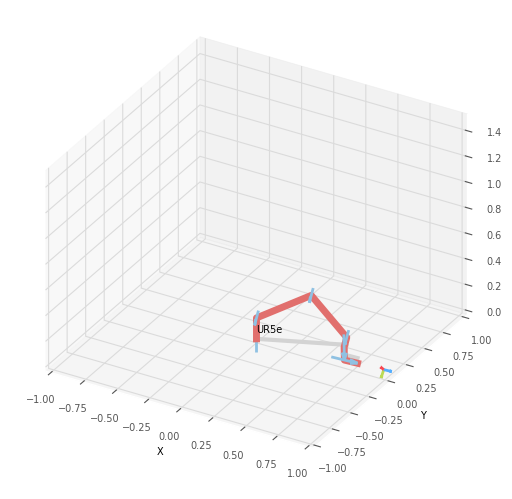

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5e')

<Figure size 640x480 with 0 Axes>

In [10]:
robotDH.plot(joint_trajectory[-1], block=False, limits=[-1, 1, -1, 1, 0, 1.5],vellipse=False)

In [ ]:
# import csv
# import os

# # Specify the file name for the log

# filename = pathlib.Path(notebook_path) / "test" / "joint_trajectory_log.csv"
# log_file = filename

# # Check if the file already exists
# if os.path.exists(log_file):
#     raise FileExistsError(f"The file '{log_file}' already exists. Please delete it or choose a different file name.")

# # Open the file in write mode
# with open(log_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
    
#     # Write a header row (optional)
#     writer.writerow(["Joint1", "Joint2", "Joint3", "Joint4", "Joint5", "Joint6"])
    
#     # Write each joint configuration to the file
#     for joint_config in joint_trajectory:
#         writer.writerow(joint_config)

# print(f"Joint trajectory successfully saved to {log_file}")

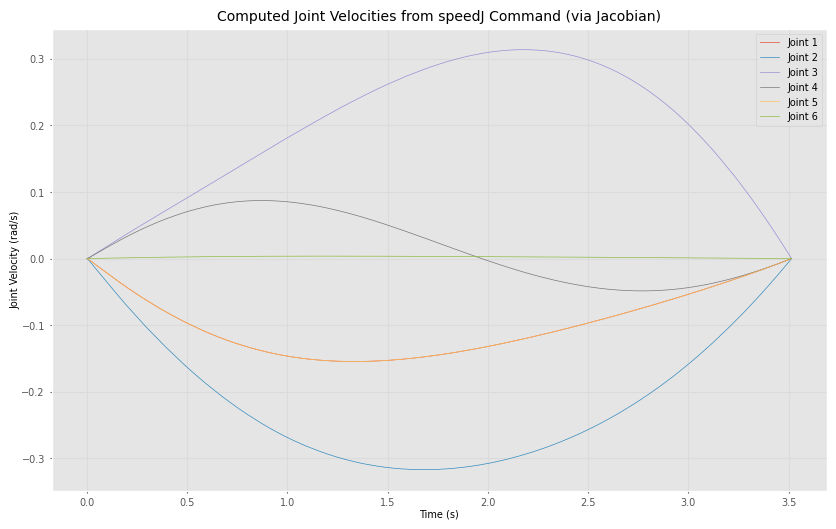

In [ ]:
# test speedJ with joint trajectory which not work! try change to speedL is better!
import numpy as np
import time
import matplotlib.pyplot as plt

# Control loop time step and joint acceleration.
joint_acceleration = 0.5  # rad/s^2
# Lists to store computed joint velocity commands and time stamps for plotting.
computed_joint_velocities = []  # Each element will be an array of joint velocities (rad/s)
time_stamps = []                 # Record the simulation time for each iteration
start_time = time.time()


for i in range(len(traj_T)):
    current_time = time.time() - start_time
    time_stamps.append(current_time)
    
    x_dot_des = speed_traj[i, :]  # Desired linear speed
    ang_vel = np.zeros(3)  # Initialize angular velocity
    x_dot_des = np.concatenate((x_dot_des, ang_vel))  # Shape: (6,)
    x_dot_des = np.array(x_dot_des, dtype=float)  # Ensure it's a numpy array
    q_current  = joint_trajectory[i]  # Current joint configuration
    # a_tcp = float(acc_scalar[i])
    # Compute the analytic Jacobian at the current joint configuration.
    J = robotDH.jacob0(q_current)  # J should be a 6x6 matrix.
    dq = np.linalg.inv(J) @ x_dot_des
    # check sigularity of Jacobian matrix
    if np.linalg.cond(J) < 1e-09:
        print("Jacobian is singular, cannot compute joint velocities.")
        break
    
    # Store the computed joint velocities for plotting later.
    computed_joint_velocities.append(dq)
    # Send the joint velocity command to the robot using the speedJ command.
    real_robot.robot_speed_J(dq.tolist(), acceleration=joint_acceleration, time=dt)
    # Delay to simulate control-loop timing.
    time.sleep(dt)
# Convert the list of computed joint velocities to a numpy array.
computed_joint_velocities = np.array(computed_joint_velocities)  # Shape: (num_steps, num_joints)


# --- Plotting the Computed Joint Velocities ---
plt.figure(figsize=(10, 6))
num_joints = computed_joint_velocities.shape[1]
for j in range(num_joints):
    plt.plot(time_stamps, computed_joint_velocities[:, j], label=f'Joint {j+1}')
plt.xlabel("Time (s)")
plt.ylabel("Joint Velocity (rad/s)")
plt.title("Computed Joint Velocities from speedJ Command (via Jacobian)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
real_robot.robot_move_speed_stop()
tcp_pose_goal = real_robot.robot_get_position()
print("Current pose after speedJ command:", tcp_pose_goal)
# cahnge rpy
pos_current_goal = tcp_pose_goal[:3]+ RPY_test
print("Current pose after speedJ command:", pos_current_goal)
real_robot.robot_moveL(pos_current_goal, speed=0.1, acceleration=0.5)



In [ ]:
real_robot.robo_move_home()
real_robot.robot_release()

Moving to home position...
Arrived at home position.


In [ ]:
# # test with speedL#1 find speed from distance and time
# import numpy as np
# import time
# import matplotlib.pyplot as plt

# # Control loop time step and Cartesian acceleration (m/s^2)
# dt = 0.01  # seconds
# cartesian_acceleration = 0.5  # adjust as needed

# # Lists to store computed Cartesian velocity commands and time stamps for plotting.
# computed_cartesian_velocities = []  # Each element will be a 6D velocity vector: [vx,vy,vz,wx,wy,wz]
# time_stamps = []  # To record the simulation time for each iteration

# start_time = time.time()

# # Loop over each waypoint in your Cartesian trajectory (traj_T).
# # This loop simulates a control-loop that sends a Cartesian velocity command using speedL.
# for i in range(len(traj_T)):
#     current_time = time.time() - start_time
#     time_stamps.append(current_time)
    
#     if i < len(traj_T) - 1:
#         # Extract the positions from the current and the next pose (assumed to be 3-element vectors)
#         pos_current = np.array(traj_T[i].t)
#         pos_next = np.array(traj_T[i+1].t)
#         # Compute the linear velocity (in m/s) required to go from pos_current to pos_next in time dt.
#         v_linear = (pos_next - pos_current) / dt
#         # For a pure linear move, we set the rotational (angular) velocity to zero.
#         v_tcp = np.concatenate((v_linear, np.zeros(3)))  # Form a 6D velocity vector.
#     else:
#         # At the final waypoint, we command zero velocity.
#         v_tcp = np.zeros(6)
    
#     # Store the computed Cartesian velocity for plotting or verification.
#     computed_cartesian_velocities.append(v_tcp)
    
#     # Send the desired Cartesian velocity to the robot using the speedL command.
#     real_robot.robot_move_speed(v_tcp.tolist(), acceleration=cartesian_acceleration, time=dt)
    
#     time.sleep(dt)  # Maintain the control loop timing

# # Convert the velocity list to a NumPy array for plotting.
# computed_cartesian_velocities = np.array(computed_cartesian_velocities)

# # --- Plotting the computed Cartesian velocities ---
# plt.figure(figsize=(10, 6))
# for j in range(6):
#     plt.plot(time_stamps, computed_cartesian_velocities[:, j], label=f'Component {j+1}')
# plt.xlabel("Time (s)")
# plt.ylabel("Cartesian Velocity (units/s)")
# plt.title("Computed Cartesian Velocities from speedL Command")
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# # test with speedL#2 find speed from cubic trajectory
# import time
# import matplotlib.pyplot as plt

# cartesian_acceleration = 0.5  # m/s^2
# computed_cartesian_velocities = []  # to store the velocity commands
# time_stamps = []
# start_time = time.time()

# # acc_traj is (N,3), so compute the magnitude at each step
# acc_scalar = np.linalg.norm(acc_traj, axis=1)  # shape (N,)


# # Loop over the trajectory time vector.
# for i in range(len(t_vec)):
#     current_time = time.time() - start_time
#     time_stamps.append(current_time)
    
#     # Extract the velocity for this timestep from the vel_traj array.
#     v_linear = speed_traj[i, :]  # This is a 3-element vector [vx, vy, vz]
#     a_tcp = acc_scalar[i]
#     # print("acc:", a_tcp)
    
#     # Construct the full 6D velocity vector (set angular to zero).
#     v_tcp = np.concatenate((v_linear, np.zeros(3)))
    
#     computed_cartesian_velocities.append(v_tcp)
    
#     # Now, send the speedL command using your robot's interface.
#     # speedJ function
#     real_robot.robot_move_speed(v_tcp.tolist(), acceleration=a_tcp, time=dt)
    
#     time.sleep(dt)

# computed_cartesian_velocities = np.array(computed_cartesian_velocities)

# # Plot the velocity profiles for verification.
# plt.figure(figsize=(10, 6))
# for j in range(6):
#     plt.plot(time_stamps, computed_cartesian_velocities[:, j], label=f'Component {j+1}')
# plt.xlabel("Time (s)")
# plt.ylabel("Cartesian Velocity (units/s)")
# plt.title("Cartesian Velocity from cubic_trajectory_planning_vector via speedL")
# plt.legend()
# plt.grid(True)
# plt.show()

# print("last velocity:", computed_cartesian_velocities[-1])

In [ ]:
# # this see how joint trajectory is smooth or not however
# # is not use due to is need to convert to speed and speed each joint is not work for this project!
# import matplotlib.pyplot as plt
# import numpy as np

# # First, convert the joint trajectory to a NumPy array for easier manipulation.
# joint_traj_array = np.array(joint_trajectory)  # shape: (N, 6)

# # Create a time vector that spans the total duration of the trajectory.
# # For plotting purposes, you can use T_total (if you already computed it) or simply index the waypoints.
# T_total = T_total  # Replace with your actual total time if computed
# num_points = joint_traj_array.shape[0]
# time_vec = np.linspace(0, T_total, num_points)

# # Plot each joint's trajectory
# plt.figure(figsize=(10, 6))
# for joint_idx in range(joint_traj_array.shape[1]):
#     plt.plot(time_vec, joint_traj_array[:, joint_idx],
#              label=f"Joint {joint_idx + 1}")

# plt.xlabel("Time (s)")
# plt.ylabel("Joint Angle (rad)")
# plt.title("Joint Trajectory over Time")
# plt.legend()
# plt.grid(True)
# plt.show()
